In [45]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import seaborn as sns
from main_data import (
    key_to_camelot,
    get_history,
    open_wheel,
    add_features,
    get_playlist,
    pickl,
    unpickl,
)


In [46]:
cid = "ec23ca502beb44ffb22173b68cd37d9a"
secret = "556c805ce20848ed94194c081f0c96a8"
sp = spotipy.Spotify(
    client_credentials_manager=SpotifyClientCredentials(
        client_id=cid, client_secret=secret
    )
)


In [47]:
# %store -r streams_df streams_af_df no_skip_df playlist_af_df
# streams_df, streams_af_df, no_skip_df, playlist_af_df = streams_df, streams_af_df, no_skip_df, playlist_af_df


In [48]:
streams_df, streams_af_df, no_skip_df, playlist_af_df, podcasts_df, wheel_df = unpickl(
    "streams_df.p",
    "streams_af_df.p",
    "no_skip_df.p",
    "playlist_af_df.p",
    "podcasts_df.p",
    "wheel_df.p",
)


In [49]:
# series2 = streams_af_df['spotify_track_uri']
# series1 = streams['spotify_track_uri']
# comparison = series1[~series1.isin(series2)]
# comparison


In [50]:
no_skip_df


,artist,track,album,duration_ms,ms_played,date,time,month,year,tempo,camelot,key_signature,start,end,shuffle,id,ts
0,Rich Boy,Throw Some D's Remix,Rich Boy,351053,351053,03/25/2021,18:43:26,03,2021,161.0,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-03-25 18:43:26+00:00
1,Rich Boy,Throw Some D's Remix,Rich Boy,351053,351053,01/21/2021,05:42:09,01,2021,161.0,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-21 05:42:09+00:00
2,Rich Boy,Throw Some D's Remix,Rich Boy,351053,433839,05/06/2021,20:25:54,05,2021,161.0,12A,D-flat minor,fwdbtn,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-05-06 20:25:54+00:00
3,Rich Boy,Throw Some D's Remix,Rich Boy,351053,351053,01/16/2021,01:47:55,01,2021,161.0,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-16 01:47:55+00:00
4,Rich Boy,Throw Some D's Remix,Rich Boy,351053,351053,01/30/2021,05:14:21,01,2021,161.0,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-30 05:14:21+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47936,James Blake,Frozen (feat. JID & SwaVay),Friends That Break Your Heart,236378,236378,09/30/2022,03:19:58,09,2022,100.0,6B,B-flat major,trackdone,trackdone,False,4IX1G5Ibs3aWyiSLUO7OPt,2022-09-30 03:19:58+00:00
47937,Teitanblood,Anteinfierno,Death,297120,297120,09/25/2021,04:34:37,09,2021,101.0,6A,G minor,clickrow,trackdone,False,2uFlPURngrcfsOz1nHgpaO,2021-09-25 04:34:37+00:00
47938,Xenia Rubinos,How Strange It Is,Black Terry Cat,192033,192032,12/06/2019,04:52:04,12,2019,112.0,11B,A major,trackdone,trackdone,False,0ta023auUvOMAhzQ4oIRF9,2019-12-06 04:52:04+00:00
47939,Master P,Meal Ticket,I'm Bout It,243840,243840,01/19/2021,01:55:48,01,2021,152.0,10B,D major,trackdone,trackdone,False,5TIGd8F70sI5mk6U4bubX8,2021-01-19 01:55:48+00:00


In [51]:
# sp.audio_features('77cVT85pU7WH3elC1SE7Uu')


In [52]:
# streams.query('spotify_track_uri in @comparison')


In [53]:
# missing_tracks = []
# for i in range(len(comparison)):
#     missing_tracks.append(sp.track(comparison.iloc[i])['external_urls'])
# missing_tracks


In [54]:
streams_af_df


,artist,track,album,duration_ms,ms_played,date,time,month,year,tempo,camelot,key_signature,start,end,shuffle,id,ts
0,Rich Boy,Throw Some D's Remix,Rich Boy,351053,351053,03/25/2021,18:43:26,03,2021,161.0,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-03-25 18:43:26+00:00
1,Rich Boy,Throw Some D's Remix,Rich Boy,351053,155956,08/07/2021,05:06:29,08,2021,161.0,12A,D-flat minor,clickrow,endplay,False,1qXLj4ywjsA0hGmaibmnn3,2021-08-07 05:06:29+00:00
2,Rich Boy,Throw Some D's Remix,Rich Boy,351053,351053,01/21/2021,05:42:09,01,2021,161.0,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-21 05:42:09+00:00
3,Rich Boy,Throw Some D's Remix,Rich Boy,351053,0,10/18/2019,18:04:48,10,2019,161.0,12A,D-flat minor,clickrow,endplay,False,1qXLj4ywjsA0hGmaibmnn3,2019-10-18 18:04:48+00:00
4,Rich Boy,Throw Some D's Remix,Rich Boy,351053,1580,02/17/2022,11:15:58,02,2022,161.0,12A,D-flat minor,fwdbtn,fwdbtn,True,1qXLj4ywjsA0hGmaibmnn3,2022-02-17 11:15:58+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85407,James Blake,Frozen (feat. JID & SwaVay),Friends That Break Your Heart,236378,236378,09/30/2022,03:19:58,09,2022,100.0,6B,B-flat major,trackdone,trackdone,False,4IX1G5Ibs3aWyiSLUO7OPt,2022-09-30 03:19:58+00:00
85408,Teitanblood,Anteinfierno,Death,297120,297120,09/25/2021,04:34:37,09,2021,101.0,6A,G minor,clickrow,trackdone,False,2uFlPURngrcfsOz1nHgpaO,2021-09-25 04:34:37+00:00
85409,Xenia Rubinos,How Strange It Is,Black Terry Cat,192033,192032,12/06/2019,04:52:04,12,2019,112.0,11B,A major,trackdone,trackdone,False,0ta023auUvOMAhzQ4oIRF9,2019-12-06 04:52:04+00:00
85410,Master P,Meal Ticket,I'm Bout It,243840,243840,01/19/2021,01:55:48,01,2021,152.0,10B,D major,trackdone,trackdone,False,5TIGd8F70sI5mk6U4bubX8,2021-01-19 01:55:48+00:00


In [55]:
streams_af_df[streams_af_df.ts.astype(str).duplicated() == True].sort_values(by="ts")


,artist,track,album,duration_ms,ms_played,date,time,month,year,tempo,camelot,key_signature,start,end,shuffle,id,ts
80751,NxWorries,Starlite,Yes Lawd!,203947,250,07/22/2019,05:29:36,07,2019,142.0,7B,F major,backbtn,backbtn,False,0AnLCkvhn3HUYkws8rgklp,2019-07-22 05:29:36+00:00
33373,NxWorries,Scared Money,Yes Lawd!,177147,0,07/22/2019,05:29:36,07,2019,170.0,7B,F major,backbtn,backbtn,False,10domQBk5oAdI8thuGJqUJ,2019-07-22 05:29:36+00:00
36199,Blood Orange,I Wanna C U,Angel's Pulse,74725,74725,08/02/2019,03:07:21,08,2019,100.0,5A,C minor,trackdone,trackdone,False,4BD3sl4HjTAzWGVIP8LLm4,2019-08-02 03:07:21+00:00
74966,Luedji Luna,Acalanto - A COLORS SHOW,Acalanto - A COLORS SHOW,249000,249000,08/02/2019,03:07:21,08,2019,170.0,8B,C major,trackdone,trackdone,False,0xDBAczBIlrlgUMjKPZOUL,2019-08-02 03:07:21+00:00
58200,Jimmy Whoo,Bingo Bingo,Bingo Bingo,196689,196689,08/02/2019,03:40:50,08,2019,105.0,2A,E-flat minor,trackdone,trackdone,False,7acwfH4FzRu00Ptd6k9SKB,2019-08-02 03:40:50+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20011,Pharoah Sanders,Astral Traveling,Thembi,350267,500,10/18/2022,05:29:09,10,2022,131.0,6B,B-flat major,fwdbtn,fwdbtn,False,55X66sKArUevBeGD7buroR,2022-10-18 05:29:09+00:00
56142,Hailu Mergia,Wede Harer Guzo,Wede Harer Guzo,395707,220,10/18/2022,05:29:10,10,2022,98.0,4A,F minor,fwdbtn,fwdbtn,False,7Ihi6UcJKndJKlsm0A4hjZ,2022-10-18 05:29:10+00:00
45100,Ahmad Jamal,Poinciana,Poinciana,273760,220,10/18/2022,05:29:10,10,2022,89.0,10B,D major,fwdbtn,fwdbtn,False,4lyupu0V7V9CoKhH52sfS8,2022-10-18 05:29:10+00:00
49276,Rochelle Jordan,Situation,Play With The Changes,253463,660,10/18/2022,05:29:19,10,2022,145.0,4A,F minor,fwdbtn,fwdbtn,False,3GtiKCRZ9pgM48q27FO7Xv,2022-10-18 05:29:19+00:00


In [56]:
# I don't recall listening to this artist so much. Investigating if it was on repeat on accident or something.

why_tala = streams_af_df.query('"Hope Tala" in artist')
why_why_tala = (
    why_tala.groupby(by="date")
    .sum(numeric_only=True)
    .sort_values(by="ms_played", ascending=False)
)
why_why_tala["ms_played"] = why_why_tala["ms_played"].apply(lambda x: x / 60000)
why_why_tala.head(50)


,duration_ms,ms_played,tempo,shuffle
date,,,,
11/27/2019,9794621,148.336600,6416.0,0
10/26/2020,5078924,84.648650,3062.0,0
12/22/2019,4569295,73.220750,2951.0,0
12/20/2019,4497827,58.939100,2928.0,0
06/21/2020,3656287,58.797417,2361.0,0
12/23/2019,3417101,53.641750,2097.0,0
12/15/2019,3189582,53.159650,2100.0,0
12/06/2019,3132015,50.620350,2099.0,0
12/24/2020,2823338,43.400650,1424.0,13


In [57]:
# Looks like I just let her run on most popular song repeat for a few hours.
streams_af_df.query('date == "11/27/2019"').sort_values(by="ts")


,artist,track,album,duration_ms,ms_played,date,time,month,year,tempo,camelot,key_signature,start,end,shuffle,id,ts
8815,Sonic Youth,Teen Age Riot (Album Version),Daydream Nation (Deluxe Edition),417800,417800,11/27/2019,01:07:12,11,2019,156.0,9B,G major,clickrow,trackdone,False,0WIbzDVEpmOyBnqqdtqIL9,2019-11-27 01:07:12+00:00
43306,The Smashing Pumpkins,1979 - Remastered 2012,Mellon Collie And The Infinite Sadness,266200,266200,11/27/2019,01:12:17,11,2019,127.0,5B,E-flat major,clickrow,trackdone,False,5QLHGv0DfpeXLNFo7SFEy1,2019-11-27 01:12:17+00:00
42592,Portishead,Cowboys,Portishead,279267,279266,11/27/2019,01:22:03,11,2019,77.0,3A,B-flat minor,clickrow,trackdone,False,1DB8s1L4z25jcRw88815ko,2019-11-27 01:22:03+00:00
13494,Hope Tala,Lovestained,Sensitive Soul,175281,175280,11/27/2019,04:30:31,11,2019,89.0,1B,B major,clickrow,trackdone,False,5I67IXwHIMi0svzyp7GxUe,2019-11-27 04:30:31+00:00
38560,Hope Tala,Anywhere,Sensitive Soul,146000,146000,11/27/2019,04:32:57,11,2019,160.0,7B,F major,trackdone,trackdone,False,3aEvOxj6rBNTpPFaBVJyGf,2019-11-27 04:32:57+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78152,Denzel Curry,YOO,ZUU,64493,464,11/27/2019,22:19:08,11,2019,73.0,11A,F-sharp minor,fwdbtn,fwdbtn,False,3kUV3AVKhoWTNFxdFkCViB,2019-11-27 22:19:08+00:00
75442,Denzel Curry,CAROLMART FEAT. ICE BILLION BERG,ZUU,164120,14675,11/27/2019,22:19:24,11,2019,155.0,3B,D-flat major,fwdbtn,endplay,False,5OO7ybh0GQlXslHX4U4Vgr,2019-11-27 22:19:24+00:00
24210,Denzel Curry,This Life,Imperial,207214,207214,11/27/2019,22:22:51,11,2019,152.0,2A,E-flat minor,clickrow,trackdone,False,2aQwdBWk4vSPWk1Csgtzdo,2019-11-27 22:22:51+00:00
40981,Denzel Curry,Zenith,Imperial,242890,242889,11/27/2019,22:26:54,11,2019,92.0,2A,E-flat minor,trackdone,trackdone,False,67T0J1IDGgRwNMp3vWYaVb,2019-11-27 22:26:54+00:00


In [58]:
no_skip_df.query('artist.str.contains("(?i)miles davis")', engine="python")


,artist,track,album,duration_ms,ms_played,date,time,month,year,tempo,camelot,key_signature,start,end,shuffle,id,ts
697,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,449773,449773,09/30/2019,21:57:11,09,2019,119.0,9B,G major,trackdone,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2019-09-30 21:57:11+00:00
698,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,449773,449010,05/28/2022,12:32:59,05,2022,119.0,9B,G major,trackdone,endplay,True,1q2Jzd23O49Crk91Rijl7Y,2022-05-28 12:32:59+00:00
699,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,449773,449773,09/05/2021,08:45:02,09,2021,119.0,9B,G major,trackdone,trackdone,True,1q2Jzd23O49Crk91Rijl7Y,2021-09-05 08:45:02+00:00
700,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,449773,449642,05/29/2021,00:22:10,05,2021,119.0,9B,G major,playbtn,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-05-29 00:22:10+00:00
701,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,449773,449773,07/17/2021,01:09:49,07,2021,119.0,9B,G major,clickrow,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-07-17 01:09:49+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47415,Miles Davis,Summertime - Mono Version,Porgy and Bess (Mono Version),198507,198506,02/21/2022,03:14:35,02,2022,106.0,4A,F minor,clickrow,trackdone,False,0YRlrc4JzUCXHLS2j5keej,2022-02-21 03:14:35+00:00
47561,Miles Davis,Go Ahead John - part two C,Miles Ahead (Original Motion Picture Soundtrack),219560,219560,11/25/2019,01:48:15,11,2019,122.0,3B,D-flat major,trackdone,trackdone,False,12hZQoeLnufiPI7l1CYfHn,2019-11-25 01:48:15+00:00
47596,Miles Davis,"Billy Boy (feat. John Coltrane, Cannonball Add...",Milestones (Mono),434893,434893,02/21/2022,23:36:48,02,2022,134.0,8B,C major,trackdone,trackdone,False,5Jm4C3t6fn5WuRZQcjwvqx,2022-02-21 23:36:48+00:00
47605,Miles Davis,"So Near, So Far",Seven Steps To Heaven,416693,416693,01/25/2020,04:56:07,01,2020,84.0,9B,G major,trackdone,trackdone,False,0CpyNb2RlzO7345kFiwXzg,2020-01-25 04:56:07+00:00


In [59]:
def top_songs(years="all", skips=False, features=True):
    if skips and features:
        df = streams_af_df
    elif not skips:
        df = df.query("(ms_played / duration_ms) > 0.51").reset_index()


pivot_track = pd.DataFrame(
    no_skip_df.query('year == "2022"')
    .pivot_table(columns=["artist", "track", "year"], aggfunc="size")
    .sort_values(ascending=False)
)

pivot_track.head(30)


,,,0
artist,track,year,
Rvdical the Kid,Nasa,2022,23
Pusha T,Brambleton,2022,23
Lava La Rue,G.O.Y.D.,2022,22
Billy Lemos,Midlife Crisis,2022,17
Lava La Rue,Cry Baby,2022,17
JPEGMAFIA,HAZARD DUTY PAY!,2022,16
SZA,Jodie,2022,16
Dua Saleh,signs,2022,16
Angel Haze,Never Seen,2022,15


In [60]:
no_skip_df.query('year == "2022"')


,artist,track,album,duration_ms,ms_played,date,time,month,year,tempo,camelot,key_signature,start,end,shuffle,id,ts
6,Rich Boy,Throw Some D's Remix,Rich Boy,351053,351053,09/13/2022,06:43:38,09,2022,161.0,12A,D-flat minor,fwdbtn,trackdone,True,1qXLj4ywjsA0hGmaibmnn3,2022-09-13 06:43:38+00:00
17,The Roots,You Got Me - Drum & Bass Mix,Things Fall Apart,297880,297880,09/27/2022,21:56:45,09,2022,162.0,10A,B minor,trackdone,trackdone,True,3aljYEbx7GiJraSrIu82kd,2022-09-27 21:56:45+00:00
19,DETO BLACK,Brag,Brag,120738,120737,07/22/2022,15:40:34,07,2022,91.0,4A,F minor,trackdone,trackdone,True,4YJ9QxYTunZGun6IsUM7kz,2022-07-22 15:40:34+00:00
20,DETO BLACK,Brag,Brag,120738,120737,09/25/2022,01:43:58,09,2022,91.0,4A,F minor,fwdbtn,trackdone,True,4YJ9QxYTunZGun6IsUM7kz,2022-09-25 01:43:58+00:00
21,Magdalena Bay,Killshot - Slowed + Reverb,Killshot,278075,280156,09/15/2022,23:41:04,09,2022,84.0,3B,D-flat major,backbtn,trackdone,True,6pdyvJQkPkwo2WoDH7tFHO,2022-09-15 23:41:04+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47925,Grizzly Bear,Half Gate,Shields,329941,329940,04/02/2022,23:22:34,04,2022,85.0,7B,F major,trackdone,trackdone,True,1hEJVJBq6WYSrjKCczuvSt,2022-04-02 23:22:34+00:00
47926,KAINA,It Was a Home,It Was a Home,215413,215412,03/07/2022,02:53:34,03,2022,164.0,11B,A major,trackdone,trackdone,False,7rIkH904aCexVHirV2Auwg,2022-03-07 02:53:34+00:00
47927,Bas Mooy,Bloedneus,Alliance VI,342912,342912,03/01/2022,01:17:31,03,2022,136.0,9B,G major,trackdone,trackdone,False,5agAhZMQ9a5dBtbgAt4S0y,2022-03-01 01:17:31+00:00
47933,Charles Stepney,Step on Step,Step on Step,237445,237444,06/08/2022,10:47:43,06,2022,105.0,8B,C major,fwdbtn,trackdone,False,16JGYp893Nuk81wo6SscAk,2022-06-08 10:47:43+00:00


In [61]:
# # Check for tracks missing from new df
# series1 = duration_prep['spotify_track_uri']
# series2 = local_features['uri']
# comparison = series1[~series1.isin(series2)]
# comparison


In [62]:
# # Show missing track URLs for further investigation; track is likely removed or yet to be analyzed for audio_features.
# missing_tracks = []
# for i in range(len(comparison)):
#     missing_tracks.append(sp.track(comparison.iloc[i])['external_urls'])
# missing_tracks


In [63]:
# Most played tracks
pivot_track = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist", "track"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_track


0
artist           track                             
myNoise          Stereo Left-Right (Test Only)  118
Teebs            Black Dove                     100
Hope Tala        Moontime                        89
Teebs            Studie                          76
Aphex Twin       Alberto Balsalm                 65
...                                             ...
Derrick Harriott Have You Seen Her                1
                 Do the Jerk                      1
Machinefabriek   Zucht 2                          1
Mackk            Forever - Cleo Reed Remix        1
박혜진 Park Hye Jin Like this                        1

[18699 rows x 1 columns]

In [64]:
# Most listened to artists by number of songs played
pivot_artist = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_artist


,0
artist,
Solange,682
Teebs,569
Frank Ocean,490
Noname,475
Tim Hecker,463
...,...
CRUX,1
Kiana Ledé,1
Pye Corner Audio,1


In [65]:
no_skip_df


,artist,track,album,duration_ms,ms_played,date,time,month,year,tempo,camelot,key_signature,start,end,shuffle,id,ts
0,Rich Boy,Throw Some D's Remix,Rich Boy,351053,351053,03/25/2021,18:43:26,03,2021,161.0,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-03-25 18:43:26+00:00
1,Rich Boy,Throw Some D's Remix,Rich Boy,351053,351053,01/21/2021,05:42:09,01,2021,161.0,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-21 05:42:09+00:00
2,Rich Boy,Throw Some D's Remix,Rich Boy,351053,433839,05/06/2021,20:25:54,05,2021,161.0,12A,D-flat minor,fwdbtn,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-05-06 20:25:54+00:00
3,Rich Boy,Throw Some D's Remix,Rich Boy,351053,351053,01/16/2021,01:47:55,01,2021,161.0,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-16 01:47:55+00:00
4,Rich Boy,Throw Some D's Remix,Rich Boy,351053,351053,01/30/2021,05:14:21,01,2021,161.0,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-30 05:14:21+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47936,James Blake,Frozen (feat. JID & SwaVay),Friends That Break Your Heart,236378,236378,09/30/2022,03:19:58,09,2022,100.0,6B,B-flat major,trackdone,trackdone,False,4IX1G5Ibs3aWyiSLUO7OPt,2022-09-30 03:19:58+00:00
47937,Teitanblood,Anteinfierno,Death,297120,297120,09/25/2021,04:34:37,09,2021,101.0,6A,G minor,clickrow,trackdone,False,2uFlPURngrcfsOz1nHgpaO,2021-09-25 04:34:37+00:00
47938,Xenia Rubinos,How Strange It Is,Black Terry Cat,192033,192032,12/06/2019,04:52:04,12,2019,112.0,11B,A major,trackdone,trackdone,False,0ta023auUvOMAhzQ4oIRF9,2019-12-06 04:52:04+00:00
47939,Master P,Meal Ticket,I'm Bout It,243840,243840,01/19/2021,01:55:48,01,2021,152.0,10B,D major,trackdone,trackdone,False,5TIGd8F70sI5mk6U4bubX8,2021-01-19 01:55:48+00:00


In [66]:
miles = no_skip_df.query('artist.str.contains("(?i)Miles Davis")')
pivot_miles = pd.pivot_table(miles, values="ms_played", index=["album"], aggfunc="sum")
pivot_miles = pivot_miles.sort_values(by="ms_played", ascending=False)
miles


,artist,track,album,duration_ms,ms_played,date,time,month,year,tempo,camelot,key_signature,start,end,shuffle,id,ts
697,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,449773,449773,09/30/2019,21:57:11,09,2019,119.0,9B,G major,trackdone,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2019-09-30 21:57:11+00:00
698,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,449773,449010,05/28/2022,12:32:59,05,2022,119.0,9B,G major,trackdone,endplay,True,1q2Jzd23O49Crk91Rijl7Y,2022-05-28 12:32:59+00:00
699,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,449773,449773,09/05/2021,08:45:02,09,2021,119.0,9B,G major,trackdone,trackdone,True,1q2Jzd23O49Crk91Rijl7Y,2021-09-05 08:45:02+00:00
700,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,449773,449642,05/29/2021,00:22:10,05,2021,119.0,9B,G major,playbtn,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-05-29 00:22:10+00:00
701,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,449773,449773,07/17/2021,01:09:49,07,2021,119.0,9B,G major,clickrow,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-07-17 01:09:49+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47415,Miles Davis,Summertime - Mono Version,Porgy and Bess (Mono Version),198507,198506,02/21/2022,03:14:35,02,2022,106.0,4A,F minor,clickrow,trackdone,False,0YRlrc4JzUCXHLS2j5keej,2022-02-21 03:14:35+00:00
47561,Miles Davis,Go Ahead John - part two C,Miles Ahead (Original Motion Picture Soundtrack),219560,219560,11/25/2019,01:48:15,11,2019,122.0,3B,D-flat major,trackdone,trackdone,False,12hZQoeLnufiPI7l1CYfHn,2019-11-25 01:48:15+00:00
47596,Miles Davis,"Billy Boy (feat. John Coltrane, Cannonball Add...",Milestones (Mono),434893,434893,02/21/2022,23:36:48,02,2022,134.0,8B,C major,trackdone,trackdone,False,5Jm4C3t6fn5WuRZQcjwvqx,2022-02-21 23:36:48+00:00
47605,Miles Davis,"So Near, So Far",Seven Steps To Heaven,416693,416693,01/25/2020,04:56:07,01,2020,84.0,9B,G major,trackdone,trackdone,False,0CpyNb2RlzO7345kFiwXzg,2020-01-25 04:56:07+00:00


In [67]:
pivot_album_time = pd.pivot_table(
    no_skip_df, values="ms_played", index=["album"], aggfunc="sum"
)


In [68]:
pivot_album_time = pivot_album_time.sort_values(by="ms_played", ascending=False)
pivot_album_time.head(20)


,ms_played
album,
Anicca,78774970
Blonde,63886996
MAGDALENE,63095348
When I Get Home,61282345
Radio Amor,59912141
Portrait with Firewood,52872004
Couldn't Wait to Tell You...,51089590
Take Me Apart,48469897
It Should Be Us,40406908


In [69]:
pivot_artist_time = pd.pivot_table(
    no_skip_df, values="ms_played", index=["artist"], aggfunc="sum"
)


In [70]:
# print(pivot_artist_time.sort_values().to_string())
artist_time = pivot_artist_time.sort_values(
    by="ms_played", ascending=False
).reset_index()
print(artist_time.to_string())


                                           artist  ms_played
0                                      Tim Hecker  137446930
1                                      Andy Stott  134478969
2                                      Aphex Twin  122666371
3                                     Frank Ocean  109787313
4                                           Teebs  108516886
5                                         Solange  103251687
6                                           DjRUM   88496378
7                                          Noname   82744746
8                            Ludwig van Beethoven   81971810
9                                     Miles Davis   77627672
10                                      Hope Tala   73859092
11                                          Smino   73336537
12                                         Kelela   72259299
13                                      FKA twigs   66840399
14                                          Liv.e   63668132
15                      

In [71]:
# Artists played more than 10 mins
repeated_artists = artist_time[:1750]
# Number of unique tracks played from those artists

len(streams_af_df["track"].unique())


27651

In [72]:
still_repeated = repeated_artists["artist"]


In [73]:
# Count number of unique tracks per artist and create ascending list
still_still_repeated = no_skip_df.query("artist in @still_repeated")
# still_still_repeated.loc[:, 'artist'] = still_still_repeated.copy().loc[:, 'artist'].astype(str)
group = still_still_repeated.groupby("artist")
songs_per_artist = group.apply(lambda x: x["track"].unique())
unique_songs = songs_per_artist.reset_index(name="unique_titles")


In [74]:
unique_songs["unique_count"] = unique_songs.iloc[:, 1].str.len()


In [75]:
unique_songs = unique_songs.sort_values(by="unique_count").reset_index()


In [76]:
unique_export = unique_songs.query("unique_count <= 8")["artist"]


In [77]:
pivot_artist_time.ms_played


artist
 Sentinel                    1653647
"Weird Al" Yankovic           202920
$ilkMoney                     988092
$oudière                      207979
$uicideboy$                   279096
                              ...   
△▃△▓                          144000
⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ    1976665
セキトオ・シゲオ                     1101414
チェスマスター                       879069
박혜진 Park Hye Jin             3797178
Name: ms_played, Length: 4194, dtype: int64

In [78]:
# Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should explore more of.
pivot_artist_time.query("ms_played > 3600000").query("artist in @unique_export")


,ms_played
artist,
A$AP Mob,3949611
ACE TEE,8488318
Aaliyah,6789210
Abdallah Oumbadougou,4595574
Afrikan Sciences,5946921
...,...
XVRHLDY,6410767
Xiu Xiu,4629407
Yusef Lateef,6855396


Todo: Next step after the above is to plot least uniques with most ms played

In [79]:
# Convert
pivot_artist_time["ms_played"] = pd.to_timedelta(pivot_artist_time.ms_played, unit="ms")


In [80]:
def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)


In [81]:
pivot_artist_time["ms_played"] = pivot_artist_time["ms_played"].apply(format_td)


In [82]:
# Show longest songs
no_skip_df.sort_values(by="ms_played", axis=0, ascending=False)


,artist,track,album,duration_ms,ms_played,date,time,month,year,tempo,camelot,key_signature,start,end,shuffle,id,ts
43835,William Basinski,Watermusic II,Watermusic II,3997680,3997680,01/28/2021,11:04:11,01,2021,71.0,7B,F major,trackdone,trackdone,False,1IERjUpo0AhB3yoxCBl7FQ,2021-01-28 11:04:11+00:00
38809,William Basinski,dlp 1.1,The Disintegration Loops,3815787,3815786,07/26/2022,10:01:01,07,2022,95.0,7B,F major,backbtn,trackdone,False,10SeyQmuBIVJmbZYYJs07W,2022-07-26 10:01:01+00:00
40254,William Basinski,dlp 1.1,The Disintegration Loops,3815787,3815786,01/28/2021,09:30:35,01,2021,95.0,7B,F major,trackdone,trackdone,False,31FiS1jMI38kYfC8ey358W,2021-01-28 09:30:35+00:00
36626,William Basinski,dlp 5,The Disintegration Loops III,3140747,3140746,02/02/2021,08:55:46,02,2021,135.0,7B,F major,trackdone,trackdone,False,36XtPJCvIs7ucoMDMIBRI7,2021-02-02 08:55:46+00:00
46567,William Basinski,El Camino Real,El Camino Real,2999520,2999520,01/28/2021,12:50:11,01,2021,142.0,3B,D-flat major,trackdone,trackdone,False,5owloXCqdMDgyXfLXrdpAc,2021-01-28 12:50:11+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7438,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3201,3200,02/21/2021,02:28:39,02,2021,0.0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:28:39+00:00
7400,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3201,3200,02/21/2021,02:29:20,02,2021,0.0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:29:20+00:00
7378,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3201,3200,02/21/2021,02:25:15,02,2021,0.0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:25:15+00:00
7437,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3201,3200,02/21/2021,02:28:47,02,2021,0.0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:28:47+00:00


<AxesSubplot: xlabel='month', ylabel='hours played'>

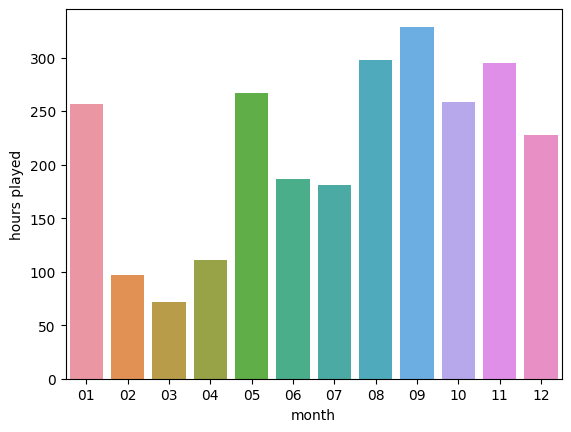

In [83]:
# How to control this for missing months? do october 25 2019 thru 2022
sns_prep = streams_af_df.query('year == "2019"| year == "2020" | year == "2021"')
sns_prep = pd.pivot_table(
    sns_prep,
    values="ms_played",
    index=["month"],
    aggfunc="sum",
).reset_index()
sns_prep["hours played"] = sns_prep["ms_played"].apply(lambda x: x / 3600000)
sns.barplot(data=sns_prep, x="month", y="hours played")


<AxesSubplot: xlabel='month', ylabel='count'>

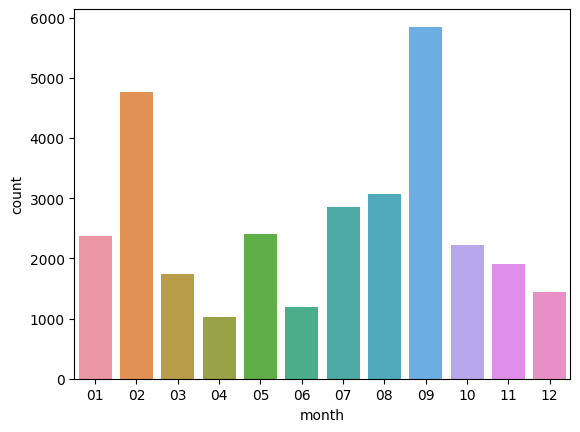

In [84]:
# sum of unique uris closely maps to total skips per month
sns_prep = streams_af_df.copy().drop_duplicates(subset="id")
sns_prep["count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration_ms", "ms_played", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


<AxesSubplot: xlabel='month', ylabel='count'>

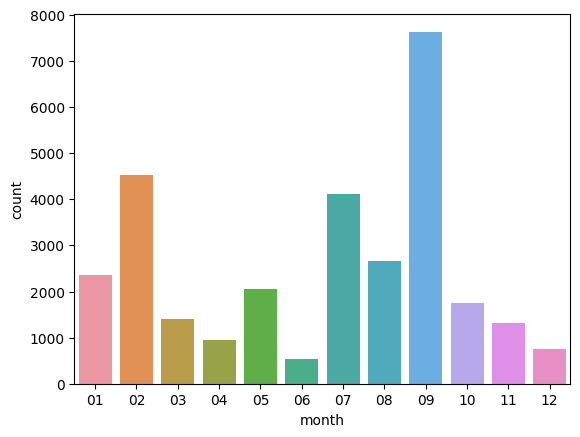

In [85]:
# good way to find months with most music discovery along with unique URIs
sns_prep = streams_af_df.copy().query("(ms_played / duration_ms) < 0.25")
sns_prep.at[:, "count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration_ms", "ms_played", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [86]:
# common keys of listened tracks
no_skip_df.loc[:, "ts"] = no_skip_df.loc[:, "ts"].astype(str)
pivot_track = pd.DataFrame(
    no_skip_df.drop_duplicates(subset="ts")
    .pivot_table(columns=["key_signature"], aggfunc="size")
    .sort_values(ascending=False)
)
pivot_track


/tmp/ipykernel_1239/1018729088.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  no_skip_df.loc[:, "ts"] = no_skip_df.loc[:, "ts"].astype(str)


,0
key_signature,
D-flat major,5439
G major,3364
C major,3311
B-flat minor,2851
D major,2742
B minor,2365
F minor,2270
A-flat major,2264
E minor,2104


In [87]:
# Todo: see if df approach is better than dict approach
# compute is about the same, probably turn this approach into a function
wheel = open_wheel()
wheel = pd.DataFrame.from_dict(wheel)
song_key = playlist_af_df.loc[1, "camelot"]
friendkey = wheel.loc["dominant_relative", song_key]
playlist_af_df.query("camelot in @friendkey")


,artist,track,album,tempo,camelot,key_signature,id
23,Zaïko Langa Langa,Ma (Part 1),"The Best From Essiebons, Vol. 21",133.0,2B,F-sharp major,115RufHm0zvrPN3MaheZ98
24,Zaïko Langa Langa,Ma (Part 2),"The Best From Essiebons, Vol. 21",127.0,2B,F-sharp major,1bu1oSPQ8CQEtvV3biJn9T
37,Amadou Balaké,N dola Abidou,Taximen,99.0,12B,E major,5pghRhAGEuCXEhvmgqYSvy
78,Gabo Brown,It's a Vanity,African Scream Contest: Raw & Psychedelic Afro...,134.0,2B,F-sharp major,59WA9oyxeyoItTiL3W92Iw
84,El Rego,Cholera,El Rego,145.0,2B,F-sharp major,7jhL61hgjJAaVcntcZi1gT
86,Amon Tobin,Nova,Permutation,81.0,2B,F-sharp major,0lcfJc4pG6xnNmrUlZ9232
99,Tommy Guerrero,SUN RAYS LIKE STILTS,Perpetuum,139.0,12B,E major,1ftzcrYAqDupTkQvoqwfGo
134,Stan Getz,Saudade Vem Correndo,Jazz Samba Encore!,91.0,12B,E major,3QxAadrRx8aSEVd6Qzr8KF
146,Dur-Dur Band,Gorof (Elixir),Sweet as Broken Dates: Lost Somali Tapes from ...,118.0,12B,E major,3ny55ZJcTqFLIcuXPzOpBF
149,Itamar Assumpção,Tua Boca,"Bicho de 7 Cabeças, Vol. 3",112.0,12B,E major,4CyG1iMACBSBxRlQY2muys


In [88]:
streams_af_df.loc[0]


artist                            Rich Boy
track                 Throw Some D's Remix
album                             Rich Boy
duration_ms                         351053
ms_played                           351053
date                            03/25/2021
time                              18:43:26
month                                   03
year                                  2021
tempo                                161.0
camelot                                12A
key_signature                 D-flat minor
start                            trackdone
end                              trackdone
shuffle                              False
id                  1qXLj4ywjsA0hGmaibmnn3
ts               2021-03-25 18:43:26+00:00
Name: 0, dtype: object